In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pysal.model import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.api as sm
# import statsmodels.formula.api as sm

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [113]:
df = pd.read_csv('ted_main.csv')

In [114]:
df.head()

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [115]:
# df.film_date = pd.to_datetime(df.film_date,unit='s')
# df = df[df.film_date.isin(pd.date_range(start='1/1/2010', end='12/31/2017'))]

In [116]:
df.related_talks = df.related_talks.apply(eval)

In [117]:
df.related_talks.apply(len).value_counts()

6    2464
3      66
1      12
2       8
Name: related_talks, dtype: int64

In [118]:
related_talks = {}

for i, talks in enumerate(df.related_talks):
    related_talks[i] = []
    
    for talk in talks:
        related_talks[i].append(talk['title'])

In [124]:
pairs = set()

titles = df.title.unique()

for i, talks in enumerate(df.related_talks):
    
    for talk in talks:
        
        if (titles[i],talk['title']) and talk['title'] in titles:
            
            pairs.add((titles[i],talk['title']))

### Moran's I
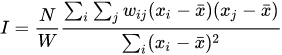

Values of I usually range from −1 to +1. Values significantly below -1/(N-1) indicate negative spatial autocorrelation and values significantly above -1/(N-1) indicate positive spatial autocorrelation. 

In [133]:
W = pd.DataFrame(np.zeros((df.title.nunique(),df.title.nunique())),
                 index=df.title.unique(),columns=df.title.unique())

In [134]:
for pair in pairs:
    W.loc[pair[0],pair[1]]+=1
#     W.loc[pair[1],pair[0]]+=1

# # Diagonal Matrix = 0
# for title in titles:
#     W.loc[title,title]+=1

In [135]:
set(list(W.to_numpy().ravel()))

{0.0, 1.0}

In [136]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(W.to_numpy())

False

In [137]:
# # transform weights into row standard weights

# horizontal_sum_W = W.sum(axis=1)
# row_std_w = W.div(horizontal_sum_W,axis=1)
# row_std_w = row_std_w.to_numpy()

# the original weights
row_std_w = W.to_numpy()
copy_w = np.copy(row_std_w)

In [138]:
# response: view
y = df.views.values
y_mean = np.mean(y)

# Num of titles in total
N = df.title.nunique()

# y-y_hat
for i in range(N):
    globals()[f'd{i}'] = y[i] - y_mean       

# list of (y-y_hat) for => Σ(y-y_hat)
D = [globals()[f'd{n}'] for n in range(N)]

# list of (y-y_hat)^2 for => Σ(y-y_hat)^2
D_sq = [d**2 for d in D]

In [139]:
# ΣiΣj wij
sum_W = np.sum(row_std_w)

# W x D:
# Wij x (Yi-Y_hat) x (Yj-Y_hat)
for i in range(N):
    for j in range(N):
        if row_std_w[i,j]!=0:
            row_std_w[i,j]*=D[i]*D[j]

In [140]:
# Conclusion: Weak positive spatial correlation

# Moran's I

# ΣiΣj(wij x (Yi-Y_hat) x (Yj-Y_hat))      N
# ----------------------------------- x --------
#          Σi(Yi-Y_hat)^2               ΣiΣj wij

moransI = (np.sum(row_std_w)/sum(D_sq)) * (N / sum_W)

print('Moran\'s I:', moransI)

Moran's I: 0.18779658589736029


#### Expected Value of Moran's I
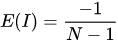
#### Variance of Moran's I
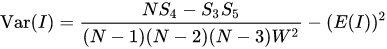
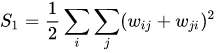
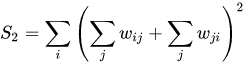
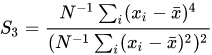



For statistical hypothesis testing, Moran's I values can be transformed to z-scores.

link: https://en.wikipedia.org/wiki/Moran%27s_I

In [141]:
# use the original weights
row_std_w = copy_w

# Calculating S1
S1 = 0

for i in range(N):
    for j in range(N):
        S1 += (row_std_w[i,j]+row_std_w[j,i])**2
        
S1 *= 0.5

# Calculating S2
S2 = 0

for i in range(N):
    sum_wij, sum_wji = 0, 0
    
    for j in range(N):
        sum_wij += row_std_w[i,j]
    for j in range(N):
        sum_wji += row_std_w[j,i]
    
    S2 += (sum_wij + sum_wji)**2
    
# Calculating S3 
D_power_of_4 = [d**4 for d in D]

S3 = (1/N * sum(D_power_of_4)) / (1/N * sum(D_sq))**2

# Calculating S4
S4 = (N**2 - 3*N + 3) * S1 - N * S2 + 3 * sum_W**2

# Calculating S5
S5 = (N**2 - N) * S1 - 2 * N * S2 + 6 * sum_W**2

In [142]:
EXP_I = -1 / (N-1)
VAR_I = (N * S4 - S3 * S5) / ((N-1) * (N-2) * (N-3) * sum_W**2) - EXP_I**2

print('Expected value E(I):', EXP_I) # the random case
print('Variance VAR(I):', VAR_I)
print('Z score of I:', (moransI-EXP_I)/VAR_I**0.5)

Expected value E(I): -0.00039231071008238524
Variance VAR(I): 8.506392099414223e-05
Z score of I: 20.40428106155949


### Moran's I Scatter Plot

In [174]:
W_Y = np.copy(copy_w)
views_series = df.views

In [181]:
i, j = np.where(W_Y>0)

first = True
lst = []
avg_list = []

for k in range(len(i)):
    if not first and i_idx != i[k]:
        avg_list.append(np.mean(lst))
        lst = []
    
    first = False
    
    i_idx, j_idx = i[k], j[k]
    
    lst.append(views_series[j_idx])
    
avg_list.append(np.mean(lst))

In [190]:
normalized_views = [(ele-np.mean(views_series.values))/np.std(views_series.values) for ele in views_series.values]
normalized_avg_list = [(ele-np.mean(avg_list))/np.std(avg_list) for ele in avg_list]

Text(0, 0.5, 'W_Views')

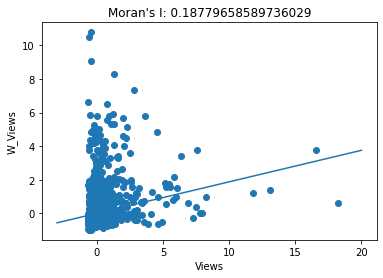

In [194]:
plt.scatter(normalized_views,normalized_avg_list)

x = np.linspace(-3,20,100)
y = moransI*x
plt.plot(x,y)

plt.title(f'Moran\'s I: {moransI}')
plt.xlabel('Views')
plt.ylabel('W_Views')

### Generate Nodes, Edges for Network Analysis

In [ ]:
nodes = pd.concat([df.title,df_tags],axis=1).reset_index()
nodes.rename(columns={'title':'label'},inplace=True)
tilte2idx = nodes.set_index('label')['index'].to_dict()

In [ ]:
edges = pd.DataFrame(pairs,columns=['Talk1','Talk2'])
edges.Talk1 = edges.Talk1.apply(lambda x: tilte2idx[x])
edges.Talk2 = edges.Talk2.apply(lambda x: tilte2idx[x])

In [ ]:
nodes.to_csv('nodes.csv',index=None)
edges.to_csv('edges.csv',index=None)

### KNN Unsupervised Learning (Extra)

In [77]:
# every single movie has a vector
W2 = csr_matrix(W)

# instantiation
knn = NearestNeighbors(metric="cosine")

# consine distance determines similarities (users, movies)
# consine angle (smaller) is inverse to similarities (higher)

knn.fit(W2)

NearestNeighbors(metric='cosine')

In [93]:
x = W.loc["How America's public schools keep kids in poverty",:].values.reshape(1,-1)
distances, indices = knn.kneighbors(x, n_neighbors=7)
indices.reshape(-1)

array([2316, 2445, 1991, 1500, 2328,  203, 1420], dtype=int64)

In [94]:
for i in range(len(indices.reshape(-1))):
  if i == 0:
    print("You are currently watching:", W.index[indices.reshape(-1)[i]])
    continue
  print("You should also watch:", W.index[indices.reshape(-1)[i]])

You are currently watching: How America's public schools keep kids in poverty
You should also watch: A summer school kids actually want to attend
You should also watch: How to fix a broken school? Lead fearlessly, love hard
You should also watch: Our failing schools. Enough is enough!
You should also watch: Help for kids the education system ignores
You should also watch: My wish: Once Upon a School
You should also watch: Kids need structure


In [88]:
df.related_talks[0]

[{'id': 865,
  'hero': 'https://pe.tedcdn.com/images/ted/172559_800x600.jpg',
  'speaker': 'Ken Robinson',
  'title': 'Bring on the learning revolution!',
  'duration': 1008,
  'slug': 'sir_ken_robinson_bring_on_the_revolution',
  'viewed_count': 7266103},
 {'id': 1738,
  'hero': 'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg',
  'speaker': 'Ken Robinson',
  'title': "How to escape education's death valley",
  'duration': 1151,
  'slug': 'ken_robinson_how_to_escape_education_s_death_valley',
  'viewed_count': 6657572},
 {'id': 2276,
  'hero': 'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg',
  'speaker': 'Linda Cliatt-Wayman',
  'title': 'How to fix a broken school? Lead fearlessly, love hard',
  'duration': 1027,
  'slug': 'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard',
  'viewed_count': 1617101},
 {'id': 892,
  'hero': 'https://pe.tedcdn.com/images/ted/e79958940573cc610ccb58